This example provides a close look at BERT (Bidirectional Encoder Representations from Transformers), one of the most popular transformer-based models, and instructs on its use in practice for sentiment analysis by fine-tuning the base model on a movie review dataset.

In [ ]:
#For this, we'll be using Hugging Face's transformers library
#loading all the neccessary libraries

In [ ]:
!pip3 install datasets

In [ ]:
!pip3 install transformers

In [ ]:
#import all the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Variables to set the number of epochs and samples
num_epochs = 10
num_samples = 100  # set this to -1 to use all data

In [ ]:
# Step 1: Load dataset and model tokenizer
#the imdb dataset has 50 000 reviews
dataset = load_dataset('imdb')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

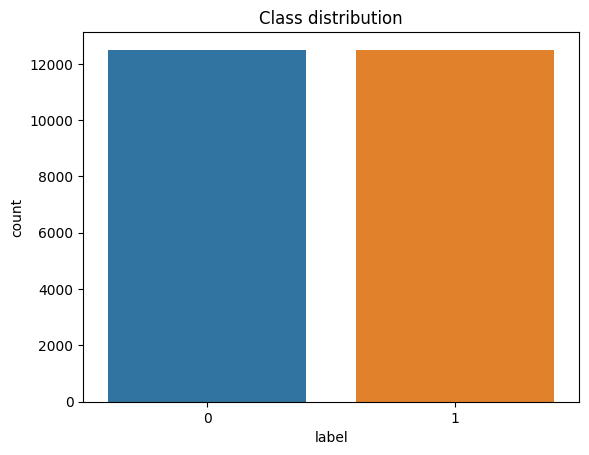

In [ ]:
# Data Exploration
#We'll create a plot to see the distribution of the positive and negative classes.
train_df = pd.DataFrame(dataset["train"])
sns.countplot(x='label', data=train_df)
plt.title('Class distribution')
plt.show()

In [ ]:
#We use BERT's tokenizer, which will convert the text into tokens that correspond to BERT's vocabulary.
# Step 2: Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
#we prepare our training and evaluation datasets.
#Remember, if you want to use all the data, you can set the num_samples variable to -1.
if num_samples == -1:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
else:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(num_samples))
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(num_samples))

In [ ]:
# Step 3: Load pre-trained model
#We'll use the AutoModelForSequenceClassification class, a BERT model designed for classification tasks.
#we use the 'bert-base-uncased' version of BERT, which is trained on lower-case English text
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install accelerate>=0.20.1

In [ ]:
# Step 4: Define training arguments
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch", no_cuda=True, num_train_epochs=num_epochs)

# Step 5: Create Trainer instance and train
trainer = Trainer(
    model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1257: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.698293
2,No log,0.693387
3,No log,0.659069
4,No log,0.770118
5,No log,0.770345


Epoch,Training Loss,Validation Loss
1,No log,0.698293
2,No log,0.693387
3,No log,0.659069
4,No log,0.770118
5,No log,0.770345
6,No log,0.827663
7,No log,0.754391
8,No log,0.808533
9,No log,0.790678
10,No log,0.799876


TrainOutput(global_step=130, training_loss=0.27372803321251504, metrics={'train_runtime': 8040.2348, 'train_samples_per_second': 0.124, 'train_steps_per_second': 0.016, 'total_flos': 263111055360000.0, 'train_loss': 0.27372803321251504, 'epoch': 10.0})

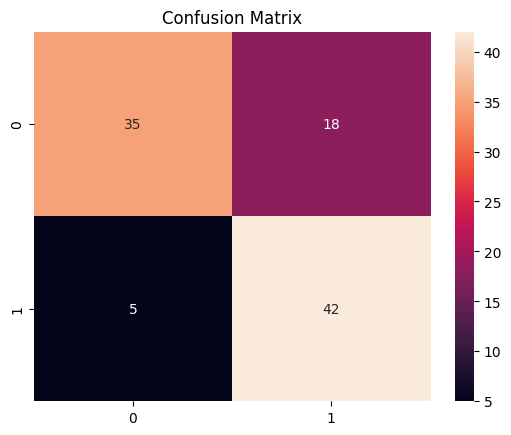

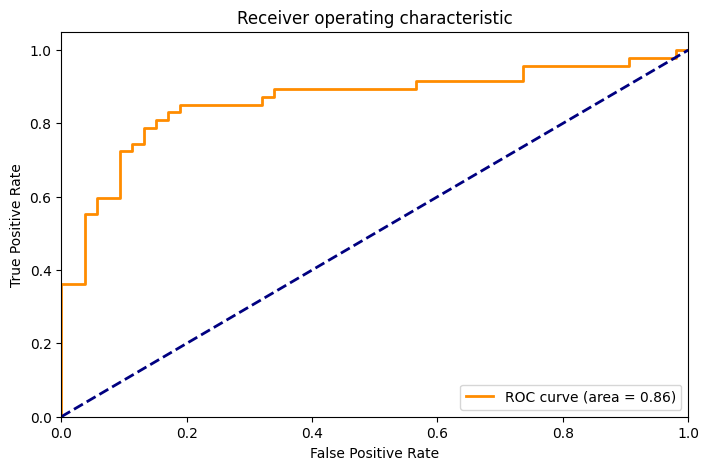

In [ ]:
# Step 6: Evaluation
predictions = trainer.predict(small_eval_dataset)

# Confusion matrix
#The confusion matrix gives a detailed breakdown of how our predictions measure up to the actual labels,
cm = confusion_matrix(small_eval_dataset['label'], predictions.predictions.argmax(-1))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
#while the ROC curve shows us the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various threshold settings.
#The area under the ROC curve (AUC-ROC) is a measure of the overall performance of the model,
#with 1.0 representing perfect classification and 0.5 indicating a model no better than random guessing.
fpr, tpr, _ = roc_curve(small_eval_dataset['label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(1.618 * 5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()